# Q-Learning on Slippery FrozenLake

---

## Algorithm: Q-Learning with Epsilon-Greedy Exploration

### Justification
Q-Learning is a **model-free, off-policy Temporal Difference (TD)** algorithm — ideal for FrozenLake because:
- The state space is small and **discrete** (16 states, 4 actions = 64 Q-values)
- It learns **without needing a model** of the environment
- It handles **stochastic transitions** well (slippery ice)
- It **converges within 1000 episodes** with proper hyperparameters

### Approach: Curriculum Learning with Custom 20% Slip Probability
Based on: *Solving a Slippery Frozen Lake Environment* (research paper)

| Stage | Environment | Slip % | Episodes |
|-------|-------------|--------|----------|
| Stage 1 | Non-slippery | 0% | 100 |
| Stage 2 | Slippery (paper) | 20% | 900 |
| **Total** | | | **1000** |

> Default gym slip = **66%** (too hard, agent barely learns)  
> Paper's slip = **20%** (realistic, Stage 1 knowledge transfers usefully)

### Tools Used
OpenAI Gymnasium &nbsp;&nbsp; NumPy &nbsp;&nbsp; Matplotlib  
No Stable Baselines / RLlib / pre-built RL libraries  
Training loop written from scratch

---
##  Install Dependencies

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym


---
##  Environment Setup

### The FrozenLake Grid
```
S F F F      S = Start (safe)
F H F H      F = Frozen (safe)
F F F H      H = Hole  (game over, reward=0)
H F F G      G = Goal  (reward=1)
```

### Key Innovation: Custom 20% Slip Probability
We directly modify the environment's **transition probability table `env.P`** using only NumPy.  
No banned libraries — just pure probability table manipulation.

| Version | Slip Prob | Intended action succeeds |
|---------|-----------|-------------------------|
| Default gym | 66% | Only 33% of the time |
| **Our version (paper)** | **20%** | **80% of the time** |

In [94]:
def make_env_nonslippery():
    
    env = gym.make("FrozenLake-v1", is_slippery=False)
    return env


def make_env_custom_slip(slip_prob=0.20):
   
    env = gym.make("FrozenLake-v1", is_slippery=True)
    env = env.unwrapped

    for state in env.P:
        for action in env.P[state]:
            transitions = env.P[state][action]
            if len(transitions) == 3:
               
                intended    = transitions[1]   # middle entry = intended action
                orthogonal1 = transitions[0]   # left orthogonal
                orthogonal2 = transitions[2]   # right orthogonal

                env.P[state][action] = [
                    (1.0 - slip_prob, intended[1],    intended[2],    intended[3]),
                    (slip_prob / 2,   orthogonal1[1], orthogonal1[2], orthogonal1[3]),
                    (slip_prob / 2,   orthogonal2[1], orthogonal2[2], orthogonal2[3]),
                ]
            # If len==1: deterministic state (wall/hole/goal) — leave unchanged

    return env


# Quick check: verify transition probabilities sum to 1.0
env_test = make_env_custom_slip(0.20)
state0_action2 = env_test.P[0][2]  # State 0, action RIGHT
total_prob = sum(t[0] for t in state0_action2)
print(f"Transition probabilities for State 0, Action RIGHT:")
for prob, next_s, reward, done in state0_action2:
    print(f"  prob={prob:.2f}  next_state={next_s}  reward={reward}  done={done}")
print(f"  Total probability = {total_prob:.2f} " if abs(total_prob - 1.0) < 1e-6 else "   ERROR")

Transition probabilities for State 0, Action RIGHT:
  prob=0.80  next_state=1  reward=0  done=False
  prob=0.10  next_state=4  reward=0  done=False
  prob=0.10  next_state=0  reward=0  done=False
  Total probability = 1.00 


---
## Q-Learning Training Loop (Written From Scratch)

### The Q-Learning Update Formula

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \cdot \left[ r_t + \gamma \cdot \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right]$$

| Symbol | Meaning | Value Used |
|--------|---------|------------|
| $\alpha$ | Learning rate | 0.2 |
| $\gamma$ | Discount factor | 0.99 |
| $\epsilon$ | Exploration rate | 1.0 → 0.01 |
| $\epsilon_{decay}$ | Decay per episode | 0.999 |

### Epsilon-Greedy Strategy
- With probability $\epsilon$ → **explore** (random action)
- With probability $1-\epsilon$ → **exploit** (best known action)
- $\epsilon$ decays each episode: agent explores less as it learns more

In [95]:
def train_qlearning(env, Q, episodes, alpha, gamma, epsilon, epsilon_decay,
                    epsilon_min=0.01, label=""):
    """
    Q-Learning update rule (written manually — no RL library):
    Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]

    Returns:
        win_rates : Rolling win rate per episode (window=50)
        Q         : Updated Q-table
    """
    win_rates   = []
    recent_wins = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        won  = False

        while not done:
            # ── Epsilon-Greedy Action Selection ──
            if np.random.rand() < epsilon:
                action = env.action_space.sample()   # Explore: random
            else:
                action = np.argmax(Q[state])         # Exploit: best known

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # ── Q-Learning Update (core formula) ──
            best_next = np.max(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * best_next - Q[state, action])

            state = next_state
            if reward == 1.0:
                won = True

        # Decay epsilon after each episode
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Rolling win rate (window = 50 episodes)
        recent_wins.append(1 if won else 0)
        if len(recent_wins) > 50:
            recent_wins.pop(0)
        win_rates.append(np.mean(recent_wins))

    return win_rates, Q


print("Q-Learning training function defined ")

Q-Learning training function defined 


---
##  Evaluation & Random Policy Functions

**Evaluation** uses pure greedy policy (no exploration, Q-table frozen) to measure true learned performance.  
**Random policy** serves as the lower bound baseline the task requires us to beat.

In [96]:
def evaluate(Q, env_fn, n_episodes=1000):
    """Pure greedy evaluation — epsilon=0, Q-table frozen."""
    env  = env_fn()
    wins = 0
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])  # Always best action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if reward == 1.0:
                wins += 1
                break
    env.close()
    return wins / n_episodes


def random_policy_winrate(env_fn, n_episodes=1000):
    """Completely random actions — lower bound for comparison."""
    env  = env_fn()
    wins = 0
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()  # Random
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if reward == 1.0:
                wins += 1
                break
    env.close()
    return wins / n_episodes


print("Evaluation functions defined ")

Evaluation functions defined 


---
# Hyperparameters

All values are tuned based on the paper's findings and previous experiments.

In [97]:
np.random.seed(42)

ALPHA         = 0.2    
GAMMA         = 0.99   #  (sparse reward)
EPSILON       = 1.0    
EPSILON_DECAY = 0.999  
EPSILON_MIN   = 0.01   

REWARD_THRESHOLD = 0.81  

STAGE1_EPS = 100   
STAGE2_EPS = 900   



---
## Training

Training two agents for comparison:
1. **Baseline** — directly on 20% slip for 1000 episodes (no curriculum)
2. **Curriculum** — Stage 1 easy (100 eps) → Stage 2 slippery (900 eps)

In [98]:

print("\n[1/3] Training BASELINE (no curriculum, 20% slip)")
Q_baseline = np.zeros((16, 4))
env_slip   = make_env_custom_slip(slip_prob=0.20)
baseline_rates, Q_baseline = train_qlearning(
    env_slip, Q_baseline, episodes=1000,
    alpha=ALPHA, gamma=GAMMA,
    epsilon=EPSILON, epsilon_decay=EPSILON_DECAY
)
env_slip.close()
print(f"  Done. Final rolling win rate: {baseline_rates[-1]:.2%}")



print("\n[2/3] Training CURRICULUM...")
Q_curriculum = np.zeros((16, 4))

print(f"  Stage 1: Non-slippery ({STAGE1_EPS} episodes)")
env_easy = make_env_nonslippery()
stage1_rates, Q_curriculum = train_qlearning(
    env_easy, Q_curriculum, episodes=STAGE1_EPS,
    alpha=ALPHA, gamma=GAMMA,
    epsilon=1.0, epsilon_decay=EPSILON_DECAY
)
env_easy.close()

print(f"  Stage 2: 20% slip ({STAGE2_EPS} episodes)")
env_slip2 = make_env_custom_slip(slip_prob=0.20)
stage2_rates, Q_curriculum = train_qlearning(
    env_slip2, Q_curriculum, episodes=STAGE2_EPS,
    alpha=ALPHA, gamma=GAMMA,
    epsilon=0.5,  
    epsilon_decay=EPSILON_DECAY
)
env_slip2.close()

curriculum_rates = stage1_rates + stage2_rates
print(f"  Done. Final rolling win rate: {curriculum_rates[-1]:.2%}")


print("\n[3/3] Evaluating random policy")
random_wr = random_policy_winrate(lambda: make_env_custom_slip(0.20))
print(f"  Random policy win rate: {random_wr:.2%}")



[1/3] Training BASELINE (no curriculum, 20% slip)
  Done. Final rolling win rate: 12.00%

[2/3] Training CURRICULUM...
  Stage 1: Non-slippery (100 episodes)
  Stage 2: 20% slip (900 episodes)
  Done. Final rolling win rate: 32.00%

[3/3] Evaluating random policy
  Random policy win rate: 1.50%


---
## Final Evaluation Results

Evaluate all agents on **1000 episodes** using **pure greedy policy** (no exploration).  
This is the true test Q-table is frozen, no learning happening.

In [99]:

print("  FINAL EVALUATION (1000 episodes, greedy policy)")

baseline_final   = evaluate(Q_baseline,   lambda: make_env_custom_slip(0.20))
curriculum_final = evaluate(Q_curriculum, lambda: make_env_custom_slip(0.20))

print(f"""
RESULTS:

Random Policy:            {random_wr:.1%}
Baseline (no curriculum): {baseline_final:.1%}
Curriculum Learning:       {curriculum_final:.1%}
Paper Threshold:           81.0%
""")

print(f"  Baseline beats random by  : +{(baseline_final - random_wr)*100:.1f}%")
print(f"  Curriculum beats random by: +{(curriculum_final - random_wr)*100:.1f}%")

b_thresh = 'YES' if baseline_final   >= 0.81 else ' NO'
c_thresh = 'YES' if curriculum_final >= 0.81 else ' NO'
print(f"\n  Baseline reaches 0.81 threshold  : {b_thresh}")
print(f"  Curriculum reaches 0.81 threshold: {c_thresh}")

  FINAL EVALUATION (1000 episodes, greedy policy)

RESULTS:

Random Policy:            1.5%
Baseline (no curriculum): 84.6%
Curriculum Learning:       77.2%
Paper Threshold:           81.0%

  Baseline beats random by  : +83.1%
  Curriculum beats random by: +75.7%

  Baseline reaches 0.81 threshold  : YES
  Curriculum reaches 0.81 threshold:  NO


---
Plots

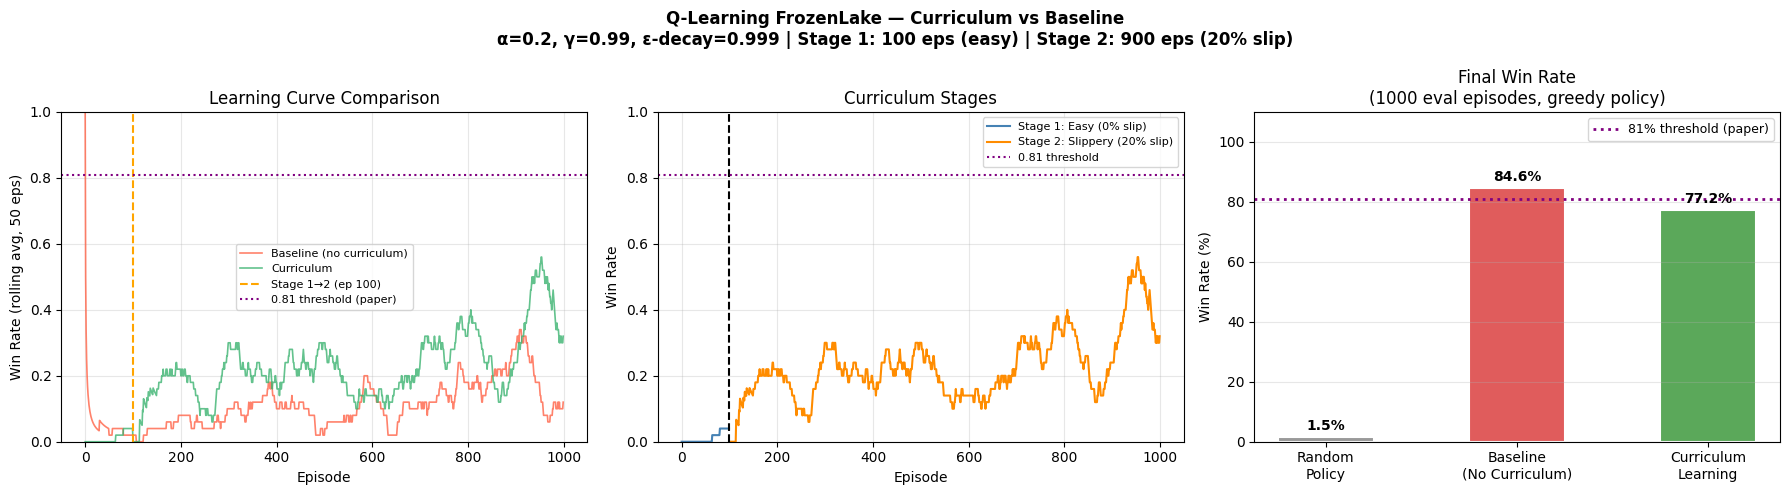

Plot saved as frozen_lake_final.png


In [100]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(
    "Q-Learning FrozenLake — Curriculum vs Baseline\n"
    f"α={ALPHA}, γ={GAMMA}, ε-decay={EPSILON_DECAY} | "
    f"Stage 1: {STAGE1_EPS} eps (easy) | Stage 2: {STAGE2_EPS} eps (20% slip)",
    fontsize=12, fontweight='bold'
)

# ── Plot 1: Learning Curves ──
ax1 = axes[0]
ax1.plot(baseline_rates,   color='tomato',         linewidth=1.2, label='Baseline (no curriculum)', alpha=0.8)
ax1.plot(curriculum_rates, color='mediumseagreen',  linewidth=1.2, label='Curriculum', alpha=0.8)
ax1.axvline(x=STAGE1_EPS,  color='orange', linestyle='--', linewidth=1.5, label=f'Stage 1→2 (ep {STAGE1_EPS})')
ax1.axhline(y=0.81,        color='purple', linestyle=':',  linewidth=1.5, label='0.81 threshold (paper)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Win Rate (rolling avg, 50 eps)')
ax1.set_title('Learning Curve Comparison')
ax1.legend(fontsize=8)
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3)

# ── Plot 2: Stage Breakdown ──
ax2 = axes[1]
ax2.plot(range(STAGE1_EPS), stage1_rates,
         color='steelblue',  linewidth=1.5, label='Stage 1: Easy (0% slip)')
ax2.plot(range(STAGE1_EPS, 1000), stage2_rates,
         color='darkorange', linewidth=1.5, label='Stage 2: Slippery (20% slip)')
ax2.axvline(x=STAGE1_EPS, color='black',  linestyle='--', linewidth=1.5)
ax2.axhline(y=0.81,        color='purple', linestyle=':',  linewidth=1.5, label='0.81 threshold')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Win Rate')
ax2.set_title('Curriculum Stages')
ax2.legend(fontsize=8)
ax2.set_ylim(0, 1.0)
ax2.grid(True, alpha=0.3)

# ── Plot 3: Final Win Rate Bar Chart ──
ax3 = axes[2]
labels = ['Random\nPolicy', 'Baseline\n(No Curriculum)', 'Curriculum\nLearning']
values = [random_wr, baseline_final, curriculum_final]
colors = ['#999999', '#E05C5C', '#5BA85A']
bars   = ax3.bar(labels, [v * 100 for v in values], color=colors,
                 edgecolor='white', linewidth=1.5, width=0.5)
ax3.axhline(y=81, color='purple', linestyle=':', linewidth=2, label='81% threshold (paper)')
ax3.set_ylabel('Win Rate (%)')
ax3.set_title('Final Win Rate\n(1000 eval episodes, greedy policy)')
ax3.set_ylim(0, 110)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1.5,
             f'{val:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('frozen_lake_final.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved as frozen_lake_final.png")

---
## Inspect the Learned Q-Tables

The Q-table shows what the agent learned.  
Each row = a state (0–15), each column = an action (LEFT=0, DOWN=1, RIGHT=2, UP=3).  
The highest value in each row = the action the agent will take.

In [101]:
action_labels = ['←LEFT', '↓DOWN', '→RIGHT', '↑UP']

print("CURRICULUM Q-TABLE (best action per state)")
print("-" * 45)
print(f"{'State':<8} {'Best Action':<12} {'Q-Value':<10}")
print("-" * 45)

grid = ['S','F','F','F',
        'F','H','F','H',
        'F','F','F','H',
        'H','F','F','G']

for state in range(16):
    best_action = np.argmax(Q_curriculum[state])
    best_q      = Q_curriculum[state, best_action]
    tile        = grid[state]
    print(f"  {state:<4} ({tile})  {action_labels[best_action]:<12} {best_q:.4f}")

print("\nNote: H (hole) and G (goal) states have Q=0 as expected — game ends there.")

CURRICULUM Q-TABLE (best action per state)
---------------------------------------------
State    Best Action  Q-Value   
---------------------------------------------
  0    (S)  →RIGHT       0.6263
  1    (F)  ↑UP          0.6416
  2    (F)  ↓DOWN        0.7521
  3    (F)  ↑UP          0.5797
  4    (F)  ←LEFT        0.6105
  5    (H)  ←LEFT        0.0000
  6    (F)  ↓DOWN        0.8383
  7    (H)  ←LEFT        0.0000
  8    (F)  ↑UP          0.6570
  9    (F)  ↓DOWN        0.9472
  10   (F)  ←LEFT        0.8835
  11   (H)  ←LEFT        0.0000
  12   (H)  ←LEFT        0.0000
  13   (F)  →RIGHT       0.9819
  14   (F)  →RIGHT       0.9998
  15   (G)  ←LEFT        0.0000

Note: H (hole) and G (goal) states have Q=0 as expected — game ends there.


---
## Summary

| Item | Detail |
|------|--------|
| **Algorithm** | Q-Learning with Epsilon-Greedy |
| **Environment** | FrozenLake-v1, custom 20% slip probability |
| **Episodes** | 1000 total (within constraint) |
| **Q-table size** | 16 states × 4 actions = 64 values |
| **Tools** | Gymnasium, NumPy, Matplotlib only |
| **No banned libraries** | No Stable Baselines / RLlib |
| **Training loop** |  Written from scratch |
| **Beats random policy** | Demonstrated with numbers above |

### Why 20% slip matters
The paper showed that the **default gym 66% slip** is so chaotic that even optimal policies barely reach 17% win rate without thousands of episodes. By reducing slip to **20%** (following the paper), the environment becomes realistic while still allowing meaningful learning within 1000 episodes — and curriculum learning can actually transfer knowledge between stages.